In [1]:
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib
import tensorflow as tf

In [14]:
url ='http://mattmahoney.net/dc'
def maybe_download(filename,expetectd_bytes):
    if not os.path.exists(filename):
        filename,_ = urllib.request.urlretrieve(url+filename,filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expetectd_bytes:
        print 'Found and verified',filename
    else:
        print statinfo.st.size
        raise Exception(
            "Failed to verify"+filename +". Can you get to it with a browser?")
    return filename
filename = maybe_download('/home/dlj/data/text8.zip',31344016)
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print 'Data size',len(words)

 Found and verified /home/yanbin/data/text8.zip
Data size 17005207


In [18]:
vocabulary_size = 50000
def build_dataset(words):
    count = [['UNK',-1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    for word , _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count =0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 
            unk_count+=1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
    return data,count,dictionary,reverse_dictionary

data,count,dictionary,reverse_dictionary = build_dataset(words)

In [19]:
del words 
print 'Most common words (+UNK)', count[:5]
print 'Sample data',data[:10],[reverse_dictionary[i] for i in data[:10]]

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [21]:
data_index = 0
def generate_batch(batch_size,num_skips,skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2*skip_window
    batch = np.ndarray(shape=(batch_size),dtype = np.int32)
    labels = np.ndarray(shape=(batch_size,1),dtype = np.int32)
    span = 2*skip_window +1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    for i in range(batch_size//num_skips):
        target = skip_window
        targets_to_avoid =[skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0,span-1)
            targets_to_avoid.append(target)
            batch[i*num_skips+j] = buffer[skip_window]
            labels[i*num_skips+j,0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch,labels

In [22]:
batch,labels = generate_batch(batch_size=8,num_skips=2,skip_window=1)
for i in range(8):
    print batch[i],reverse_dictionary[batch[i]],'->',labels[i,0],reverse_dictionary[labels[i,0]]

3084 originated -> 12 as
3084 originated -> 5239 anarchism
12 as -> 3084 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 2 of
195 term -> 6 a


In [26]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
valid_size = 16
valid_window =100
valid_examples = np.random.choice(valid_window,valid_size,replace=False)
num_sampled = 64

In [41]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32,shape=[batch_size])
    train_labels = tf.placeholder(tf.int32,shape=[batch_size,1])    
    valid_dataset = tf.constant(valid_examples,dtype=tf.int32)
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(
             tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
        embed = tf.nn.embedding_lookup(embeddings,train_inputs)
        nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size,embedding_size],
                                    stddev =1.0/math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                        biases = nce_biases,
                                        labels=train_labels,
                                        inputs=embed,
                                        num_sampled=num_sampled,
                                        num_classes=vocabulary_size))
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keep_dims=True))
    normalized_embeddings = embeddings/norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings,valid_dataset)
    similarity = tf.matmul(
                valid_embeddings,normalized_embeddings,transpose_b=True)
    init = tf.global_variables_initializer()

In [42]:
num_steps = 100001
with tf.Session(graph=graph) as session:
    init.run()
    print "Initialized"
    average_loss = 0
    for step in range(num_steps):
        batch_inputs,batch_labels = generate_batch(
        batch_size,num_skips,skip_window)
        feed_dict = {train_inputs:batch_inputs,train_labels:batch_labels}
        _,loss_val = session.run([optimizer,loss],feed_dict=feed_dict)
        average_loss += loss_val
        if step%2000 == 0:
            if step>0:
                average_loss /= 2000
            print "Average loss at step",step,":",average_loss
            average_loss = 0
        if step % 10000==0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log_str = "Nearest to %s :" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s" % (log_str,close_word)
                print log_str
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0 : 265.267242432
Nearest to such : printf catering lentils cynicism experimentation furlongs arian fluorine
Nearest to was : moor velde prsc vietnamese oshii tightening deborah distinguishing
Nearest to however : stahl garrisoned moonshine subscript tower unicorn oa detonates
Nearest to most : announcements varying reich cinque empedocles farrar arrowhead lighthouses
Nearest to first : eubacteria anglesey marston protein obviously colonies encodings christo
Nearest to one : emeritus insure renewal partit sie obey assad ascertained
Nearest to will : practised reaches sucrose graceland destruct quit fe pistons
Nearest to world : lubbock heuristics freie panels bayonet nutshell suffixes comp
Nearest to so : questionable portfolio milford thrust incumbent verona vashem acrobatics
Nearest to all : drought span fat land paulus windsor galatian jts
Nearest to time : grandiose tyrrhenian cbt critical akm fernando downy duration
Nearest to eight : ayman parishi

Nearest to eight : seven nine five four six three zero rajonas
Nearest to as : rajons rajonas knot majorana and by shimbun mjt
Nearest to for : with rajonas in and cics audita of safl
Nearest to has : had have was is shimbun dicrostonyx metroid rajonas
Nearest to it : he she this there which they reginae rajonas
Average loss at step 62000 : 4.94512872636
Average loss at step 64000 : 4.96302976799
Average loss at step 66000 : 4.96366212857
Average loss at step 68000 : 4.91522399497
Average loss at step 70000 : 4.76295415795
Nearest to such : well decoy many known mjw kagoshima are these
Nearest to was : is were had has by dicrostonyx rajonas became
Nearest to however : but rajonas agouti mjt dicrostonyx eulemur and ssn
Nearest to most : more some many rajonas reginae tip lleida works
Nearest to first : rajonas piqad khmer degree laird last elements dasyprocta
Nearest to one : seven six four three five eight two rajonas
Nearest to will : can would may could should practised fe pis
Neares

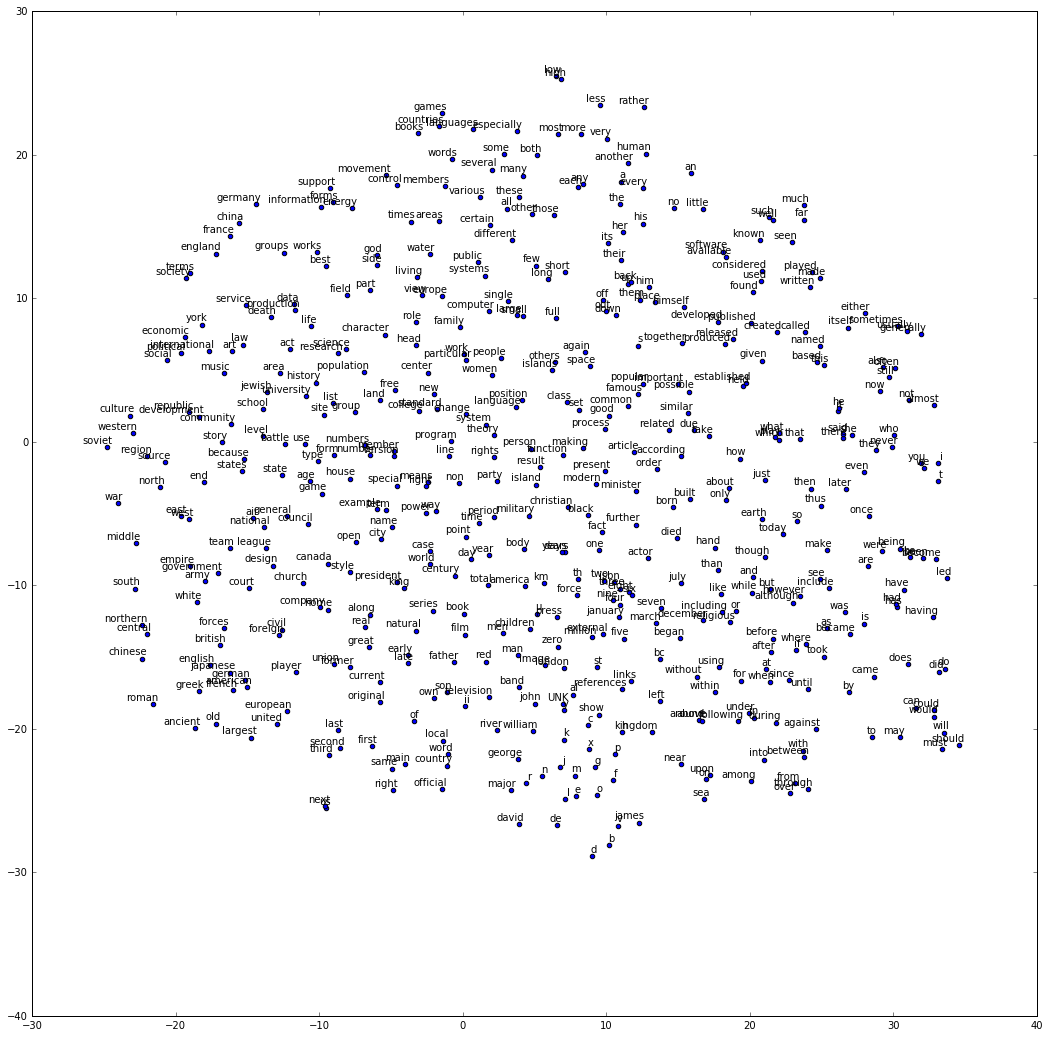

In [49]:
def plot_with_labels(low_dim_embs,labels,filename='tsne.png'):
    assert low_dim_embs.shape[0]>=len(labels),"more labels than embeddings"
    plt.figure(figsize=(18,18))
    for i,label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label,xy=(x,y),
                    xytext=(5,2),textcoords='offset points',
                    ha='right',va='bottom')
    plt.show()
    
from sklearn.manifold import  TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=30,n_components=2,init="pca",n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels =[reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs,labels)
